In [144]:
#Download data

import yfinance as yf
symbol = 'AUDUSD=X'
df =yf.Ticker(symbol).history(start='2010-01-01',period='1D')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-01-01 00:00:00+00:00,0.898311,0.898473,0.897827,0.898473,0,0.0,0.0
2010-01-04 00:00:00+00:00,0.897424,0.913910,0.894214,0.912492,0,0.0,0.0
2010-01-05 00:00:00+00:00,0.912825,0.917347,0.909504,0.911826,0,0.0,0.0
2010-01-06 00:00:00+00:00,0.911826,0.921914,0.910415,0.920471,0,0.0,0.0
2010-01-07 00:00:00+00:00,0.920302,0.926183,0.916422,0.917768,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-03-03 00:00:00+00:00,0.673500,0.676590,0.672988,0.673500,0,0.0,0.0
2023-03-06 00:00:00+00:00,0.675461,0.677100,0.671720,0.675461,0,0.0,0.0
2023-03-07 00:00:00+00:00,0.673310,0.674900,0.659560,0.673310,0,0.0,0.0


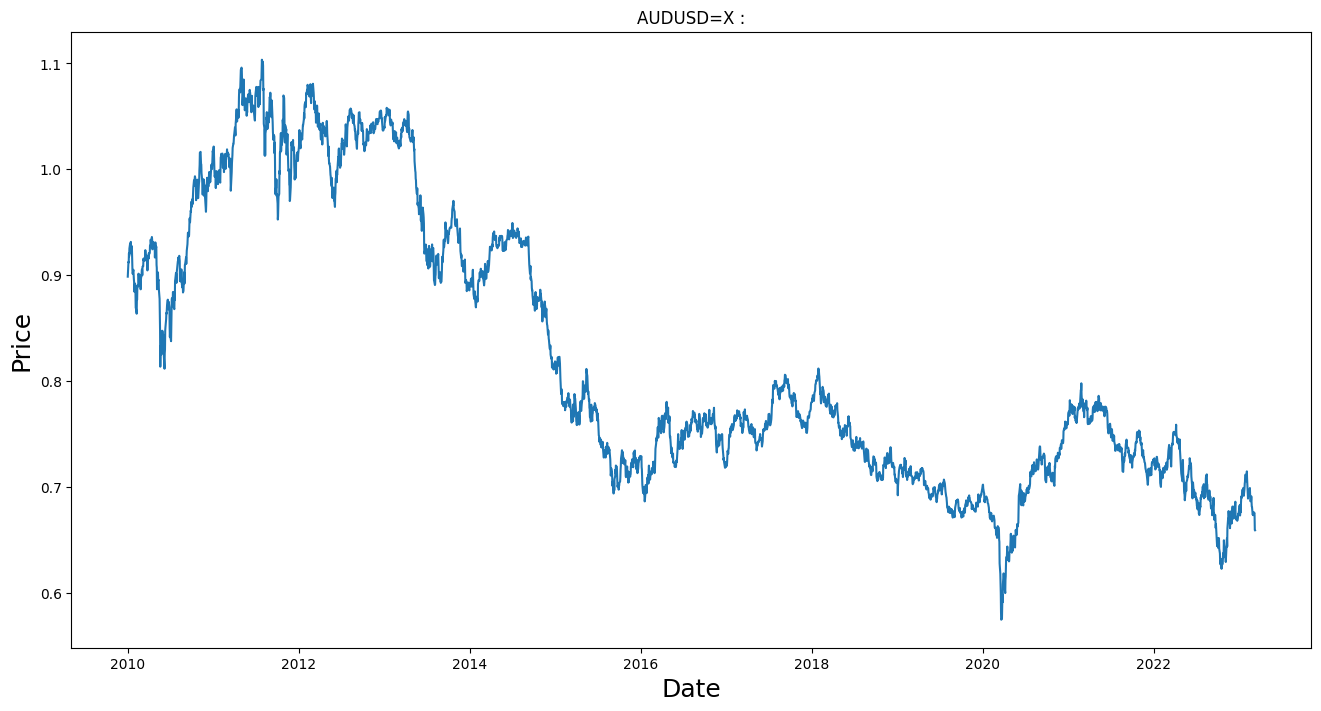

In [145]:
#plot first data
from matplotlib import pyplot as plt
plt.figure(figsize=(16,8))
plt.title(f'{symbol} :')
plt.plot(df['Close'])
plt.xlabel('Date' , fontsize = 18)
plt.ylabel('Price' , fontsize = 18)
plt.show()



In [146]:
#Build model
from keras.models import  Sequential, load_model
from keras.layers import Dense,LSTM,Dropout
from datetime import datetime
import json
from pathlib import Path
from dateutil import parser
import pandas as pd
import numpy as np


count_train = 100

path_model = f'data/saved_model/{symbol}'
train_param_path = f'data/saved_model/{symbol}/saved_train_data.json'
last_date = df.tail(1).index.to_pydatetime()[0]
add_volume = False if df['Volume'].max() == 0 else True
input_shape = [count_train, 2] if add_volume else  [count_train, 1] 
train_param = { "last_date":last_date.isoformat(), "input_shape" :input_shape}


check_path = Path(train_param_path)

train_param_load = {}
train_param_load['input_shape'] = None

def max_min_insert(key, df,param ):
    param[f'{key}_min'] = float(df.min())
    param[f'{key}_max'] = float (df.max())


if(check_path.is_file()):
    with open(train_param_path, "r") as read_content:
        train_param_load = json.load(read_content)

model_loaded = False

if train_param['input_shape'] == train_param_load['input_shape']:    
    model_loaded = True
    last_date_load= parser.parse(train_param_load['last_date'])
    from_date =  pd.to_datetime(last_date_load)
    train_param['price_min'] = train_param_load['price_min']
    train_param['price_max'] = train_param_load['price_max']
    train_param['volume_min'] = train_param_load['volume_min']
    train_param['volume_max'] = train_param_load['volume_max']
    model = load_model(path_model)
else:
    model = Sequential()
    model.add(LSTM(50, return_sequences=False, input_shape = input_shape ))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer = 'adam' , loss="mse")
    from_date = df.head(1).index[0]
    max_min_insert('price', df['Close'], train_param)
    max_min_insert('volume', df['Volume'], train_param)


from_index = df.index.get_loc(from_date)
from_index = from_index - count_train  if (from_index - count_train) > 0 else 0

output_cell = 'Model loaded' if model_loaded else 'New Model'
print(f'{output_cell} ; from the index= {from_index} To index = {len(df) -1 - count_train }')




New Model ; from the index= 0 To index = 3333


In [147]:
#filter close data
price = df.filter(['Close'])
price = price.values
volume = df.filter(['Volume'])
volume = volume.values




price_scaled =((price - train_param['price_min'])/( train_param['price_max']- train_param['price_min']))
volume_scaled = ((volume -  train_param['volume_min'])/( train_param['volume_max']- train_param['volume_min'])) if add_volume else np.array([])



print(train_param )




{'last_date': '2023-03-09T00:00:00+00:00', 'input_shape': [100, 1], 'price_min': 0.5742902159690857, 'price_max': 1.10349702835083, 'volume_min': 0.0, 'volume_max': 0.0}


In [148]:
#all data prepare
data = []
for index , pr in enumerate(price_scaled):
    row =  np.array([pr[0], volume_scaled[index][0]]) if add_volume else np.array([pr[0]])
    data.append(row)
    


data = np.array(data)
data.shape

(3434, 1)

In [149]:
#Prepare train data

x_train = []
y_train = []



for i in range(count_train, len(data)):
    x_train.append(data[i-count_train:i, :])
    y_train.append(data[ i, 0])


x_train , y_train = np.array(x_train) , np.array(y_train)


filtred_x_train = x_train[from_index:]
filtred_y_train = y_train[from_index:]
print(filtred_x_train.shape)
print(filtred_y_train.shape)



(3334, 100, 1)
(3334,)


In [150]:
#Train model

model.fit(filtred_x_train, filtred_y_train, batch_size=1, epochs=2 )


Epoch 1/2
3334/3334 [==============================] - 136s 40ms/step - loss: 7.6419e-04
Epoch 2/2
3334/3334 [==============================] - 139s 42ms/step - loss: 2.7878e-04


In [151]:
#save model


model.save(path_model)

with open(train_param_path, "w") as outfile:
    json.dump(train_param, outfile)

INFO:tensorflow:Assets written to: data/saved_model/AUDUSD=X/assets


INFO:tensorflow:Assets written to: data/saved_model/AUDUSD=X/assets


In [152]:
#prediction
def correction(val):
    return val * (train_param['price_max'] -train_param['price_min'])+train_param['price_min']
x_predict = np.array([data[-count_train:]])
prediction = model.predict(x_predict)
last_y_train = y_train[-1]
choice = 'buy' if prediction - last_y_train > 0 else 'sell'
print( f'{symbol} ; last: ( date = {last_date.strftime("%m/%d/%Y")} val = {correction(last_y_train)} ); prediction =  {round(float((correction(prediction)-correction(last_y_train)) / correction(last_y_train) *100), 3)} %. You must {choice}')




1/1 [==============================] - 1s 507ms/step
AUDUSD=X ; last: ( date = 03/09/2023 val = 0.6588179469108582 ); prediction =  0.774 %. You must buy
